In [36]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
names_df = pd.read_csv("/kaggle/input/gender-based-names/name_gender.csv")

In [3]:
names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95025 entries, 0 to 95024
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        95025 non-null  object 
 1   Gender      95025 non-null  object 
 2   confidence  95025 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.2+ MB


In [4]:
def preprocess(names_df, train=True):
    # Step 1: Lowercase
    names_df['Name'] = names_df['Name'].str.lower()

    # Step 2: Split individual characters
    names_df['Name'] = [list(name) for name in names_df['Name']]

    # Step 3: Pad names with spaces to make all names same length
    name_length = 50
    names_df['Name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['Name']
    ]

    # Step 4: Encode Characters to Numbers
    names_df['Name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['Name']
    ]
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['Gender'] = [
            0.0 if gender=='F' else 1.0 
            for gender in names_df['Gender']
        ]
    
    return names_df

names_df = preprocess(names_df)
names_df.head()

,Name,Gender,confidence
0,"[1.0, 1.0, 2.0, 1.0, 14.0, 0.0, 0.0, 0.0, 0.0,...",1.0,1.0
1,"[1.0, 1.0, 2.0, 8.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0
2,"[1.0, 1.0, 2.0, 9.0, 4.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,1.0
3,"[1.0, 1.0, 2.0, 18.0, 9.0, 5.0, 12.0, 12.0, 1....",0.0,1.0
4,"[1.0, 1.0, 4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,1.0


In [5]:
def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [6]:
# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

2023-01-16 17:13:52.058226: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# Step 2: Split Training and Test Data
X = np.asarray(names_df['Name'].values.tolist())
y = np.asarray(names_df['Gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)


In [8]:
# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)


2023-01-16 17:14:10.787946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1188/1188 [==============================] - 773s 644ms/step - loss: 0.4144 - accuracy: 0.8107 - val_loss: 0.3674 - val_accuracy: 0.8395
Epoch 2/5
1188/1188 [==============================] - 762s 641ms/step - loss: 0.3481 - accuracy: 0.8482 - val_loss: 0.3310 - val_accuracy: 0.8574
Epoch 3/5
1188/1188 [==============================] - 757s 637ms/step - loss: 0.3194 - accuracy: 0.8625 - val_loss: 0.2937 - val_accuracy: 0.8745
Epoch 4/5
1188/1188 [==============================] - 761s 641ms/step - loss: 0.2927 - accuracy: 0.8760 - val_loss: 0.2732 - val_accuracy: 0.8851
Epoch 5/5
1188/1188 [==============================] - 746s 628ms/step - loss: 0.2701 - accuracy: 0.8865 - val_loss: 0.2576 - val_accuracy: 0.8929


In [9]:
# Step 4: Save the model
model.save('boyorgirl_5.h5')

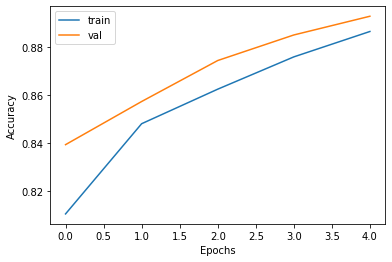

In [10]:
# Step 5: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing: Predictions

In [11]:
#Load the model
pred_model = load_model('boyorgirl_5.h5')

In [31]:
# Input names
names = ['akshaya']

# Convert to dataframe
pred_df = pd.DataFrame({'Name': names})

# Preprocess
pred_df = preprocess(pred_df, train=False)

# Predictions
result = pred_model.predict(np.asarray(
    pred_df['Name'].values.tolist())).squeeze(axis=1)

pred_df['Boy or Girl?'] = [
    'Boy' if logit > 0.5 else 'Girl' for logit in result
]

pred_df['Probability'] = [
    logit if logit > 0.5 else 1.0 - logit for logit in result
]

# Format the output
pred_df['Name'] = names
#pred_df.rename(columns={'Name': 'Name'}, inplace=True)
pred_df['Probability'] = pred_df['Probability'].round(2)
pred_df.drop_duplicates(inplace=True)

pred_df.head()

,Name,Boy or Girl?,Probability
0,akshaya,Girl,0.7


**If you like my work, Please Upvote**
**Thank you**